## Function code as of now

In [1]:
import os
import anndata
import sys
import numpy as np
wd = '/home/clarice/Documents/SingleCell_PseudoTime/'
os.chdir(wd)
sys.path.append('extras/Stabilized_ICA')

from scycle.preprocess import quality_control, prep_pooling
from scycle.tools import dimensionality_reduction, enrich_components, principal_circle

def renormalize_by_partition(adata_src, adata_ref, verbose = True):
    #-- Run QC
    params = adata_ref.uns['scycle']
    pp_params = params['preprocess']
    dr_params = params['dimRed']

    quality_control(adata_src,
                    min_counts = pp_params['min_counts'], 
                    max_counts = pp_params['max_counts'], 
                    max_mt_ratio = pp_params['max_mt_ratio'],
                    verbose = False)
    old_totals = adata_src.obs['total_counts']
    
    #---- Check if samples are the same
    if not np.all(adata_src.obs.index.values == adata_ref.obs.index.values):
        raise Exception ( 'adata_ref must contain cells in adata_src')
    
    #--- Apply filter
    if verbose: print('Normalizing by partition...')

    #---- Get partitions and re-noralize
    prt = adata_ref.obs['partition']
    gexp = adata_src.X
    
    npart = np.max(prt)+1
    new_gexp = np.empty(gexp.shape)
    for p in range(npart):
        sidx = prt == p # sample index
        totals = np.sum(gexp[sidx,:], axis = 1) # total counts per sample in group
        median = np.median(totals) # median counts for samples in group
        new_gexp[sidx,:] = gexp[sidx,:] / totals[:,None] * median
        
    #---- Re-run procedure
    adata_src.X = new_gexp
    
    if verbose: print('Re-running pooling...')
    
    prep_pooling(adata_src, 
                 filter_cells = False,
                 embed_n_comps=pp_params['embed_n_comps'],
                 min_counts = pp_params['min_counts'], 
                 max_counts = pp_params['max_counts'], 
                 max_mt_ratio = pp_params['max_mt_ratio'],
                 n_neighbors = pp_params['n_neighbors'],
                 normalize_counts = False,
                 filter_var_genes = pp_params['filter_var_genes'],
                 log_transform= pp_params['log_transform'],
                 n_top_genes = pp_params['n_top_genes'],
                 verbose = False)
    
    if verbose: print('Re-running dimensionality reduction..')
    dimensionality_reduction(adata_src,
                             method = dr_params['method'],
                             n_comps = dr_params['n_comps'],
                             seed = dr_params['seed'],
                             verbose = False)
    if 'enrich_components' in params.keys():    
        if verbose: print('Re-running component enrichment...')
        enrich_components(adata_src, verbose = False)
    
    if verbose: print('Finding the principal circle...')
    principal_circle(adata_src, n_nodes = params['principal_circle']['n_nodes'], verbose = False)
    
    adata_src.obs['total_counts'] = np.sum(adata_src.X, axis = 1)
    adata_src.obs['total_counts_raw'] = old_totals

## Pipeline start

In [2]:
sces = anndata.read_loom('data/CHLA9.loom')
sces.var_names_make_unique()

#-- Hack to make this work (need to figure out why it fails with sparse matrix)
sces = anndata.AnnData(X = sces.X.toarray(), obs = sces.obs, var = sces.var)
sces.obs['total_counts'] = sces.obs['TotalUMIs']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
import scycle as cc
sces_raw = sces.copy()

#-- Pre-process
cc.pp.prep_pooling(sces)
cc.pp.score_cell_cycle(sces)
#-- Find the trajectory
cc.tl.dimensionality_reduction(sces, method = 'ica')
cc.tl.enrich_components(sces)

Preparing embedding...
3823 samples pass the count filter
4599  samples pass the mt filter
Samples selected 3746


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Embedding for pooling...
Pooling 3746 samples...


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


-- Scoring G1 genes...
-- Scoring S-phase...
-- Scoring G2-M...


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


-- Scoring Histones...
Found histone genes: H4C3 H2AZ1 H3-3B H1-5 H1-3 H1-10 H1-2 H1-4 H2AZ2 H2AX H1-0 H2AC20 H3-3A H3C2 H2AC12 H2AJ H2BC4 H2AC16 H4C11 H3C13 H2AC14 H2BC5 H2AC15 H2AW H2AC8 H2BC6 H2AC6 H2AC21 H2AC17 H2BC15 H19 H3C3 H2BC19P H3C11 H3C12 H2BC13 H4C14 H4C8
-- Scalling signatures...
-- Dimensionality reduction using ICA...


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


-- Done
--- Selected components:
G1/S: 0
G2/M: 8
G2/M-: 5
Histones: 1


/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide


### Re-normalization on 30 partitions

In [4]:
#-- Re-normalize
sces30 = sces_raw.copy()
cc.tl.principal_circle(sces, n_nodes = 30)
renormalize_by_partition(sces30, sces)

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  3746  points and  4  dimensions
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	56427.0978	4	4	4	0	0	0	39163.9973	36512.2729	0.6434	0.6675	2760.225	14502.8754	58011.5018	232046.007	0
0||5	46163.8853	5	5	5	0	0	0	30893.6536	27830.8143	0.7187	0.7466	3256.5906	12013.6411	60068.2053	300341.0264	0
0||6	38115.9547	6	6	6	0	0	0	25559.8736	22631.176	0.7673	0.7939	3386.9504	9169.1307	55014.7844	330088.7063	0
0||7	33734.473	7	7	7	0	0	0	23076.3553	20328.6

/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Normalizing by partition...
Re-running pooling...


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Re-running dimensionality reduction..
Re-running component enrichment...
Finding the principal circle...
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  3746  points and  4  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 

/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide


13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	22244.4254	30	30	30	0	0	0	16865.3279	16197.7573	0.8681	0.8734	3045.8308	2333.2667	69997.9999	2099939.9968	0


0.8938  seconds elapsed


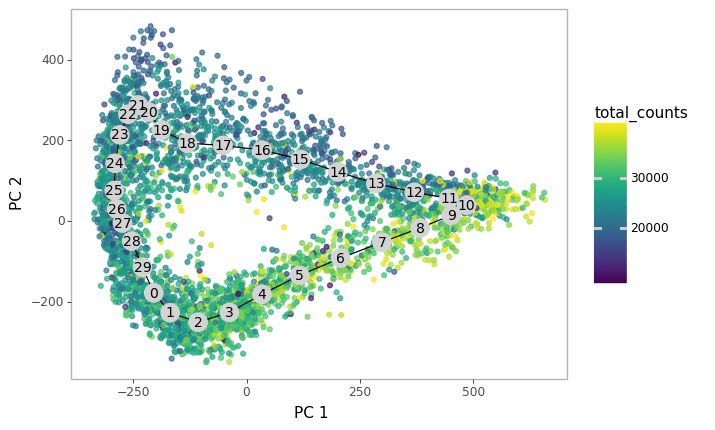

<ggplot: (8755981147145)>

In [5]:
#-- Before renormalization: 
cc.pl.scatter_projection(sces, trajectory = True)

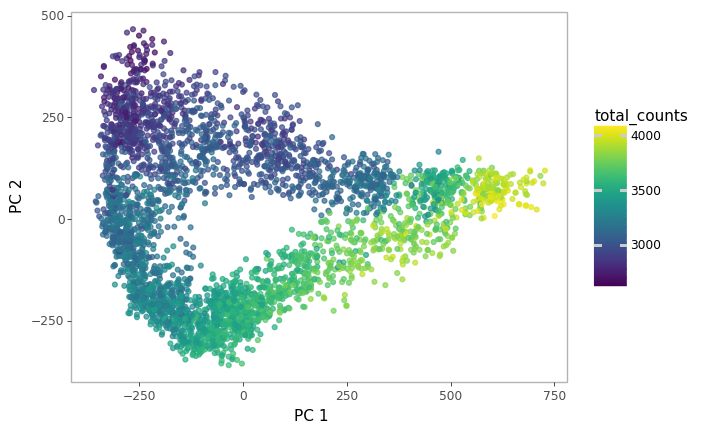

<ggplot: (8755964765141)>

In [6]:
#-- After renormalization
cc.pl.scatter_projection(sces30)

### 10 partitions

In [7]:
#-- Re-normalize
sces10 = sces_raw.copy()
cc.tl.principal_circle(sces, n_nodes = 10)
renormalize_by_partition(sces10, sces)

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  10  nodes on  3746  points and  4  dimensions
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	56427.0978	4	4	4	0	0	0	39163.9973	36512.2729	0.6434	0.6675	2760.225	14502.8754	58011.5018	232046.007	0
0||5	46163.8853	5	5	5	0	0	0	30893.6536	27830.8143	0.7187	0.7466	3256.5906	12013.6411	60068.2053	300341.0264	0
0||6	38115.9547	6	6	6	0	0	0	25559.8736	22631.176	0.7673	0.7939	3386.9504	9169.1307	55014.7844	330088.7063	0
0||7	33734.473	7	7	7	0	0	0	23076.3553	20328.6

/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Normalizing by partition...
Re-running pooling...


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Re-running dimensionality reduction..
Re-running component enrichment...
Finding the principal circle...
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  10  nodes on  3746  points and  4  dimensions
Nodes =  3 4 5 6 7 8 9 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||10	25778.338	10	10	10	0	0	0	18374.2237	16454.729	0.8443	0.8606	3300.1437	4103.9706	41039.7064	410397.0636	0


0.0847  seconds elapsed


/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide


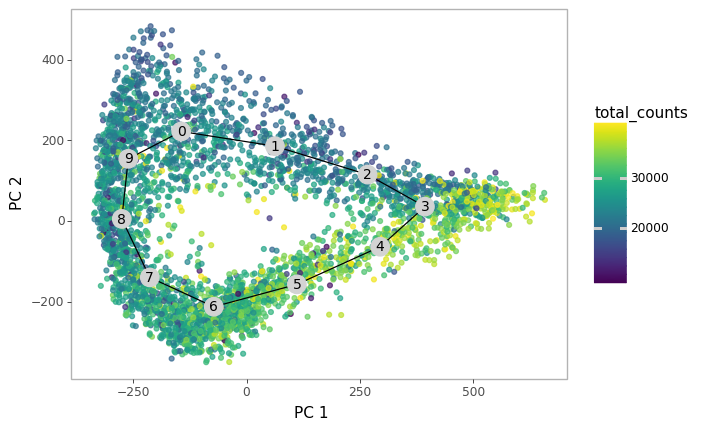

<ggplot: (8755963060201)>

In [8]:
#-- Before renormalization: 
cc.pl.scatter_projection(sces, trajectory = True)

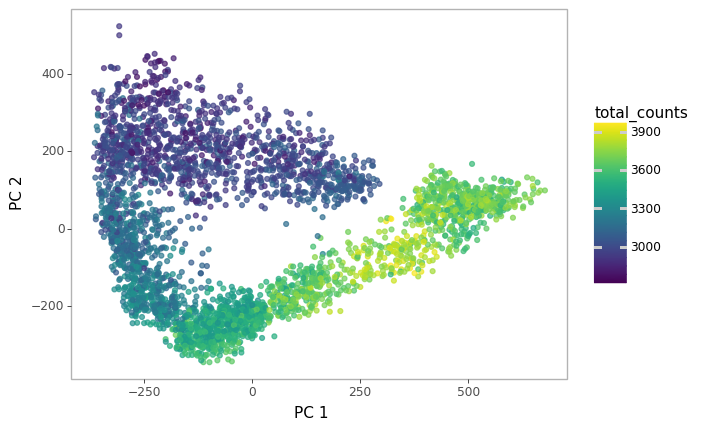

<ggplot: (8755964790073)>

In [9]:
#-- After renormalization
cc.pl.scatter_projection(sces10)

### 4 partitions

In [11]:
#-- Re-normalize
sces4 = sces_raw.copy()
cc.tl.principal_circle(sces, n_nodes = 4)
renormalize_by_partition(sces4, sces)

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  4  nodes on  3746  points and  4  dimensions
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	56427.0978	4	4	4	0	0	0	39163.9973	36512.2729	0.6434	0.6675	2760.225	14502.8754	58011.5018	232046.007	0
0.0125  seconds elapsed


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Normalizing by partition...
Re-running pooling...


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Re-running dimensionality reduction..
Re-running component enrichment...
Finding the principal circle...
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  4  nodes on  3746  points and  4  dimensions
Nodes =  3 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	58183.187	4	4	4	0	0	0	39213.4212	36948.6813	0.6644	0.6837	3029.9105	15939.8552	63759.4209	255037.6837	0


0.0096  seconds elapsed


/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide


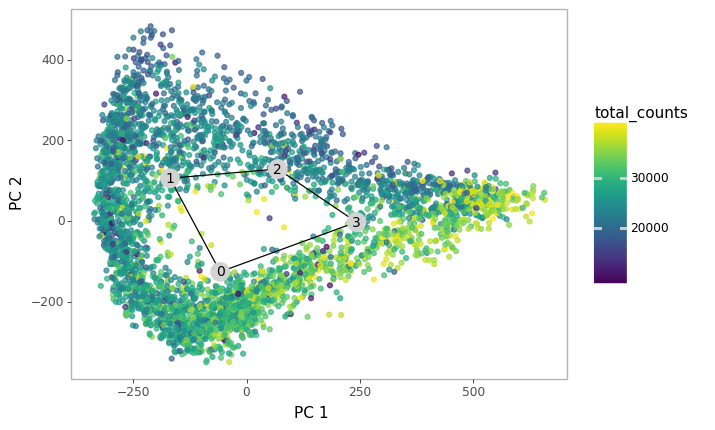

<ggplot: (8755962812501)>

In [12]:
#-- Before renormalization: 
cc.pl.scatter_projection(sces, trajectory = True)

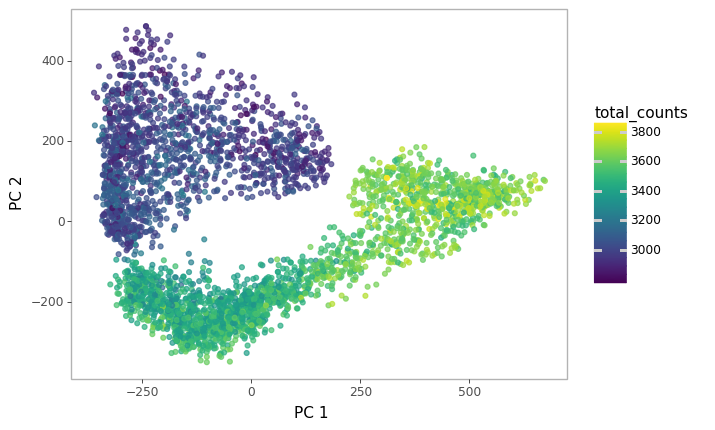

<ggplot: (8755962761157)>

In [13]:
#-- After renormalization
cc.pl.scatter_projection(sces4)